In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


## Preparation

In [107]:
df = pd.read_csv('csv/capture1_1.csv')

In [108]:
df2 = pd.read_csv('csv/capture21_1.csv')
df2 = df2.drop(['Unnamed: 0', 'orig_bytes', 'resp_bytes'], axis=1)
print(f"{df2.shape}\n")
print(f'{df2.dtypes}\n')

(2123, 6)

orig_h    int64
orig_p    int64
resp_h    int64
resp_p    int64
proto     int64
label     int64
dtype: object



In [109]:
SOURCEDF = df.copy(deep=True)
SOURCEDF = SOURCEDF.drop(['Unnamed: 0'], axis=1)
print(f"{SOURCEDF.shape}\n")
print(f'{SOURCEDF.dtypes}\n')
print(f"data categories = [Malicious: {SOURCEDF[SOURCEDF['label'] == 1].shape[0]}, Benign: {SOURCEDF[SOURCEDF['label'] == 0].shape[0]}]")
SOURCEDF.head()


(1008745, 6)

orig_h    int64
orig_p    int64
resp_h    int64
resp_p    int64
proto     int64
label     int64
dtype: object

data categories = [Malicious: 539471, Benign: 469274]


,orig_h,orig_p,resp_h,resp_p,proto,label
0,3232261223,50627,238428813,23,1,1
1,3232261223,43763,2396638396,11065,2,0
2,3232261223,40584,3542525043,23,1,1
3,3232261223,59334,331139160,2323,1,1
4,3232261223,49700,3684511560,23,1,1


## Visualise Data

In [110]:
def viz(df):
    for label in df.columns:
        plt.hist(df[df["label"] == 1][label], color='blue', label='Malicious', alpha=0.7, density=1)
        plt.hist(df[df["label"] == 0][label], color='red', label='Benign', alpha=0.7, density=1)
        plt.title(label)
        plt.ylabel('?')
        plt.xlabel(label)
        plt.legend()
        plt.show()

# viz(SOURCEDF)

## Scaling of data

In [111]:
from sklearn.preprocessing import StandardScaler
# used to sample the data in a way, that the dataset is equally distributed between categories
from imblearn.over_sampling import RandomOverSampler


In [112]:
def split(df):
    train, valid, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
    return train.reset_index(drop=True), valid.reset_index(drop=True), test.reset_index(drop=True)

In [113]:
def scale(df: pd.DataFrame, oversample = False):
    X = df.drop(['label'], axis=1)
    y = df['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    if oversample:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(X, y)

    data = np.hstack((X, np.reshape(y, (-1, 1))))
    return data, X, y

In [114]:
train, valid, test = split(SOURCEDF)


In [115]:
print(train.head())
print(valid.head())

       orig_h  orig_p      resp_h  resp_p  proto  label
0  3232261223   43763  1890653046   41741      2      0
1  3232261223   45475  3069115252   58017      1      0
2  3232261223   53684  3467077246    8080      1      1
3  3232261223   43763    70272318   52892      2      0
4  3232261223   35638   727351948    8080      1      1
       orig_h  orig_p      resp_h  resp_p  proto  label
0  3232261223   51031   773215249      23      1      1
1  3232261223   43763  2958345113    5751      2      0
2  3232261223   43763  1436256731    1676      2      0
3  3232261223   58901  2588368510      23      1      1
4  3232261223   44895  1618111721    2323      1      1


In [116]:
train, X_train, y_train = scale(train, True) 
# hier machen wir auch garkein oversampling, das ist auf false
valid, X_valid, y_valid = scale(valid, False) 
test, X_test, y_test = scale(test, False) 
test2, X_test2, y_test2 = scale(df2, False)

In [117]:
print(y_test)
# print(valid.head())

0         0
1         0
2         0
3         1
4         1
         ..
201744    1
201745    1
201746    1
201747    0
201748    1
Name: label, Length: 201749, dtype: int64


# kNN

In [118]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [119]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [120]:
y_pred = knn_model.predict(X_test)

In [126]:
res = pd.DataFrame(y_pred).join(y_test)
res.columns = ['train', 'test']
res = res.join(pd.DataFrame(X_test))
res.columns = ['train', 'test', 'orig_h', 'orig_p', 'resp_h', 'resp_p', 'proto']
res.head()

,train,test,orig_h,orig_p,resp_h,resp_p,proto
0,0,0,-0.802709,-4.587208,1.029695,-0.823781,-2.658338
1,0,0,0.093380,-0.066828,1.913518,0.079495,1.173292
2,0,0,0.093380,-0.066828,0.003577,1.400099,1.173292
3,1,1,0.093380,0.355254,-0.222583,-0.411405,-0.742523
4,1,1,0.093380,0.687671,0.204417,-0.822760,-0.742523


<Axes: xlabel='resp_h', ylabel='resp_p'>

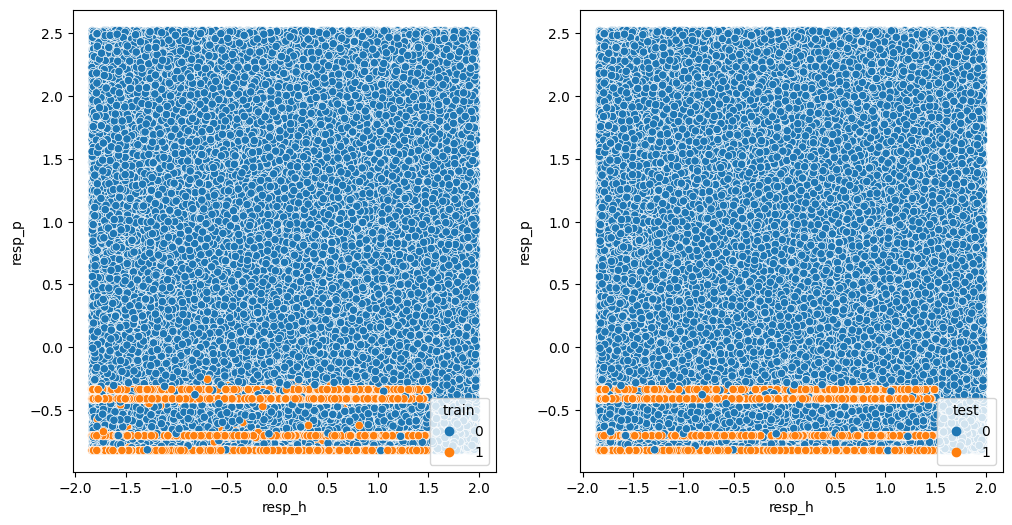

In [129]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
sns.scatterplot(data=res, x='resp_h', y='resp_p', hue='train', ax=ax1)
sns.scatterplot(data=res, x='resp_h', y='resp_p', hue='test', ax=ax2)

In [15]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       1.00      0.99      1.00     94184
   malicious       0.99      1.00      1.00    107565

    accuracy                           1.00    201749
   macro avg       1.00      1.00      1.00    201749
weighted avg       1.00      1.00      1.00    201749



# Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB

In [17]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [18]:
y_pred = nb_model.predict(X_test)

In [19]:
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.47      1.00      0.64     94184
   malicious       0.00      0.00      0.00    107565

    accuracy                           0.47    201749
   macro avg       0.23      0.50      0.32    201749
weighted avg       0.22      0.47      0.30    201749



/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/radprime/Documents/LCSProject/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

# Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.99      0.96      0.97     94184
   malicious       0.97      0.99      0.98    107565

    accuracy                           0.98    201749
   macro avg       0.98      0.97      0.98    201749
weighted avg       0.98      0.98      0.98    201749



In [23]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(X_train, y_train)
y_pred = lg_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

              precision    recall  f1-score   support

      benign       0.99      0.96      0.97     94184
   malicious       0.97      0.99      0.98    107565

    accuracy                           0.98    201749
   macro avg       0.98      0.97      0.98    201749
weighted avg       0.98      0.98      0.98    201749



In [26]:
for solver in ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']:
    # solver='liblinear', C=10.0,`
    lg_model = LogisticRegression(solver=solver, C=10.0)
    lg_model = lg_model.fit(X_train, y_train)
    print(f"score for model {solver}: {lg_model.score(X_test2, y_test2)}")
# y_pred = lg_model.predict(X_test)
# print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

score for model lbfgs: 0.42110221384832786
score for model liblinear: 0.42110221384832786
score for model newton-cg: 0.42110221384832786
score for model newton-cholesky: 0.42110221384832786
score for model sag: 0.42110221384832786
score for model saga: 0.42110221384832786


In [47]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 90482,   3580],
       [  1335, 106352]])

In [49]:
ct = pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)
ct

Predicted,0,1,All
True,,,
0,90482,3580,94062
1,1335,106352,107687
All,91817,109932,201749


# SVM

from sklearn.svm import SVC

svm_model = SVC()
svm_model = svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['benign', 'malicious']))

# Neural Net

In [2]:
import tensorflow as tf

2023-06-20 10:07:59.510500: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 10:08:00.096353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-20 10:08:00.098753: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 10:08:01.804197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


KeyboardInterrupt: 

In [ ]:
def plot_nn(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.plot(history.history['loss'], label='loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    ax2.plot(history.history['accuracy'], label='accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.show()




In [ ]:
def nn_train(X_train: pd.DataFrame, y_train: pd.DataFrame, X_valid: pd.DataFrame, y_valid: pd.DataFrame, epochs: int, nodes: int, dropout_prob: float, lr: int, batch_size: int):
    """Train a neural network

    Args:
        Y_train (pd.DataFrame): [the training data X]
        y_train (pd.DataFrame): [the training data y]
        X_valid, y_valid (pd.DataFrame): [validation data for the model, instead of doing learning rate for validation_split with 0.2]
        epochs (int): [the epochs, how many times the model goes through its training processs]
        nodes (int): how many nodes are created in each dense layer
        dropout_prob (float): [the probability of the dropout layer]
        lr (int): [the learning rate of the optimizer]
        batch_size (int): [the batch size]
    """    
    assert epochs < 1000, "Epochs too big"
    assert nodes <= 128, "Nodes too big"
    assert 0 <= dropout_prob < 1, "Dropout Prob must be probability"
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(nodes, activation='relu', input_shape=(5,)),
        # take certain nodes at a specific rate, and dont train them
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(nodes, activation='relu'),
        tf.keras.layers.Dropout(dropout_prob),
        # this will set the output to 0 or 1, which helps with the classification
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
    history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
    return nn_model, history


16 nodes, dropout_prob 0.2, lr 0.005, batch size 32


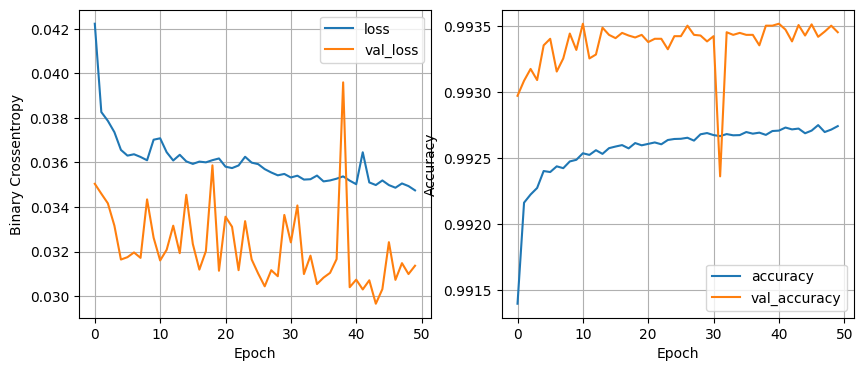

6305/6305 [==============================] - 5s 729us/step - loss: 0.0314 - accuracy: 0.9935
16 nodes, dropout_prob 0.2, lr 0.005, batch size 64


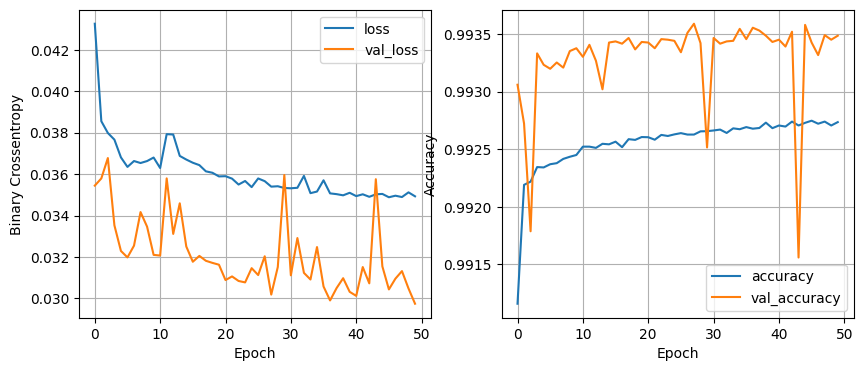

6305/6305 [==============================] - 5s 751us/step - loss: 0.0297 - accuracy: 0.9935
16 nodes, dropout_prob 0.2, lr 0.001, batch size 32


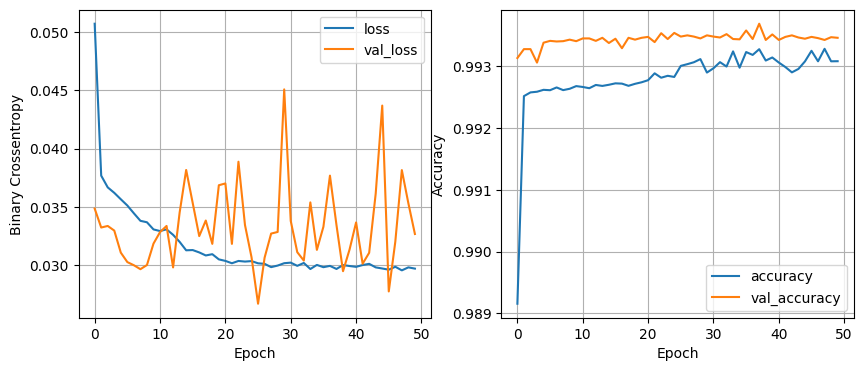

6305/6305 [==============================] - 5s 774us/step - loss: 0.0327 - accuracy: 0.9935
16 nodes, dropout_prob 0.2, lr 0.001, batch size 64


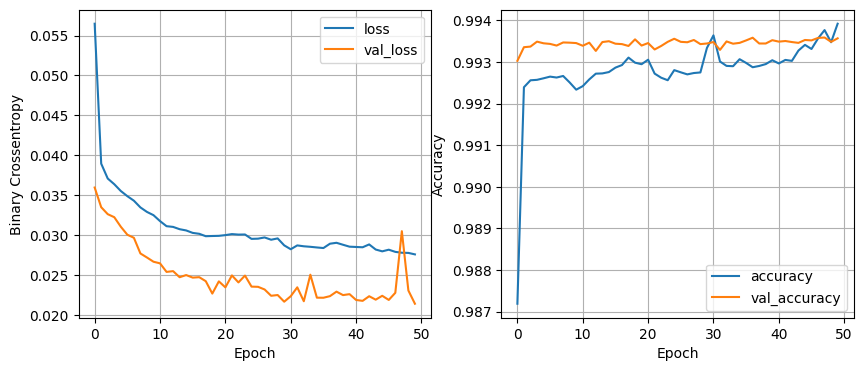

6305/6305 [==============================] - 5s 766us/step - loss: 0.0214 - accuracy: 0.9936
32 nodes, dropout_prob 0.2, lr 0.005, batch size 32


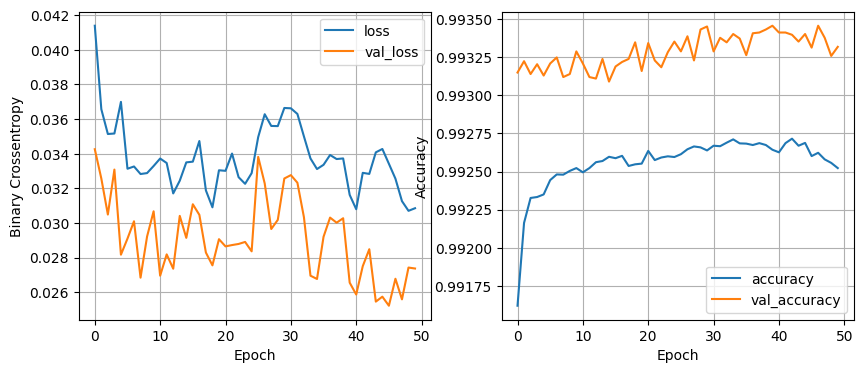

6305/6305 [==============================] - 5s 788us/step - loss: 0.0274 - accuracy: 0.9933
32 nodes, dropout_prob 0.2, lr 0.005, batch size 64


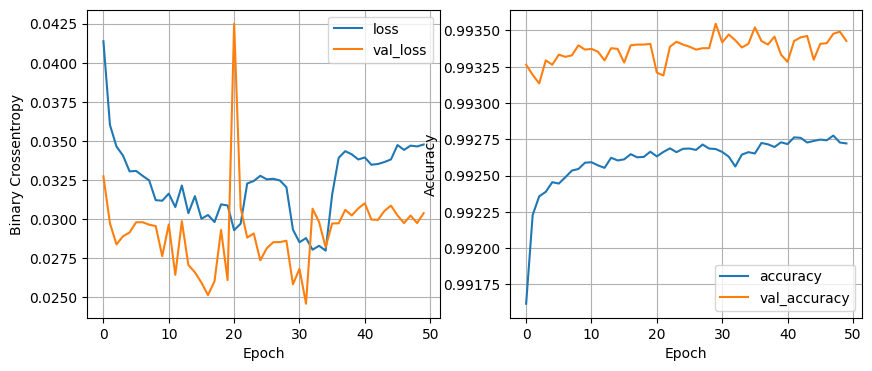

6305/6305 [==============================] - 5s 760us/step - loss: 0.0304 - accuracy: 0.9934
32 nodes, dropout_prob 0.2, lr 0.001, batch size 32


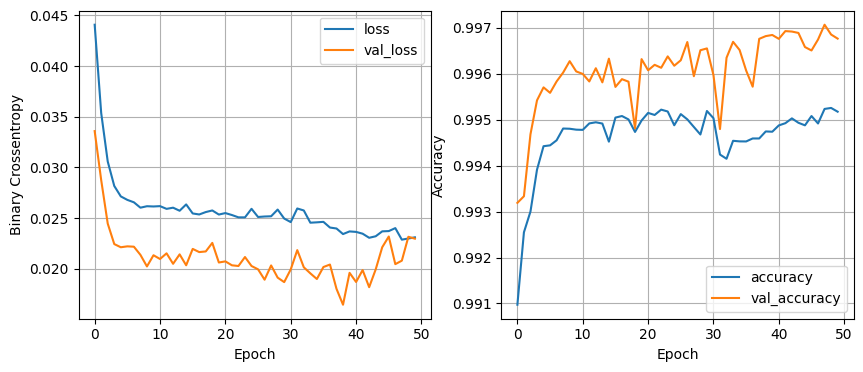

6305/6305 [==============================] - 5s 808us/step - loss: 0.0230 - accuracy: 0.9968
32 nodes, dropout_prob 0.2, lr 0.001, batch size 64


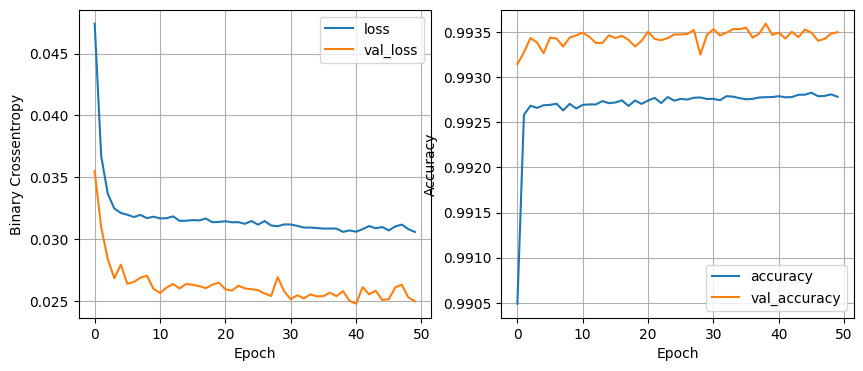

6305/6305 [==============================] - 5s 745us/step - loss: 0.0250 - accuracy: 0.9935
64 nodes, dropout_prob 0.2, lr 0.005, batch size 32


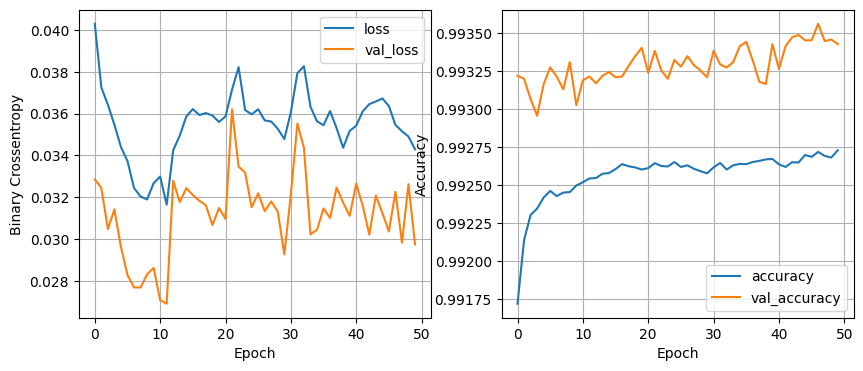

6305/6305 [==============================] - 5s 781us/step - loss: 0.0297 - accuracy: 0.9934
64 nodes, dropout_prob 0.2, lr 0.005, batch size 64


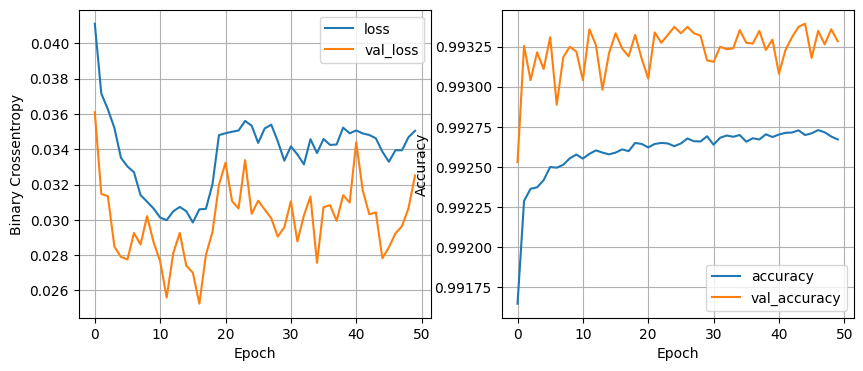

6305/6305 [==============================] - 5s 773us/step - loss: 0.0325 - accuracy: 0.9933
64 nodes, dropout_prob 0.2, lr 0.001, batch size 32


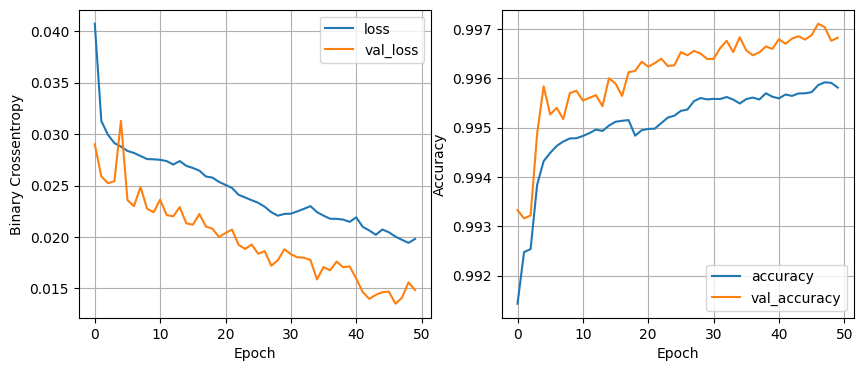

6305/6305 [==============================] - 5s 790us/step - loss: 0.0148 - accuracy: 0.9968
64 nodes, dropout_prob 0.2, lr 0.001, batch size 64


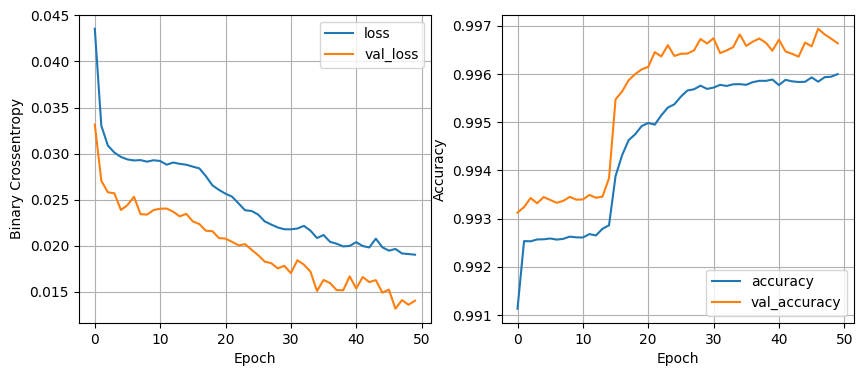

6305/6305 [==============================] - 5s 793us/step - loss: 0.0140 - accuracy: 0.9966


In [ ]:
least_val_loss = float('inf')
least_loss_model = None
epochs = 50
for nodes in [16, 32, 64]:
    for dropout_prob in [0.2]:
        for lr in [0.005, 0.001]:
            for batch_size in [32, 64]:
                print(f"{nodes} nodes, dropout_prob {dropout_prob}, lr {lr}, batch size {batch_size}")
                model, history = nn_train(X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid, epochs=epochs, nodes=nodes, dropout_prob=dropout_prob, lr=lr, batch_size=batch_size)
                plot_nn(history=history)
                val_loss = model.evaluate(X_test, y_test)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model
